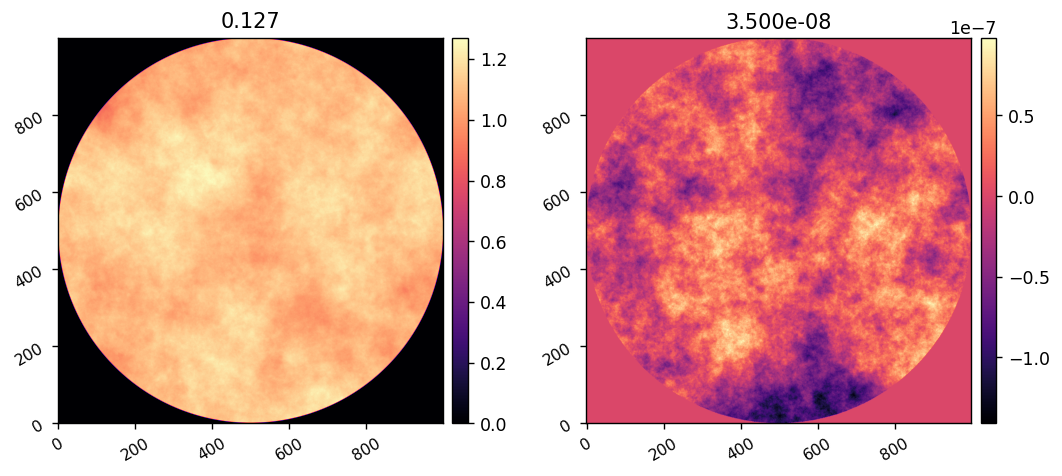

In [45]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import scoobpsf
import scoobpsf.ad_scoob_oop as ad_scoob
import scoobpsf.ad_efc as ad_efc
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

from scipy.signal import windows
from scipy.optimize import minimize

reload(utils)
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=650*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = 650e-9/2/np.pi * xp.angle(WFE)
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

# Establish the forward model parameters.

In [2]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE

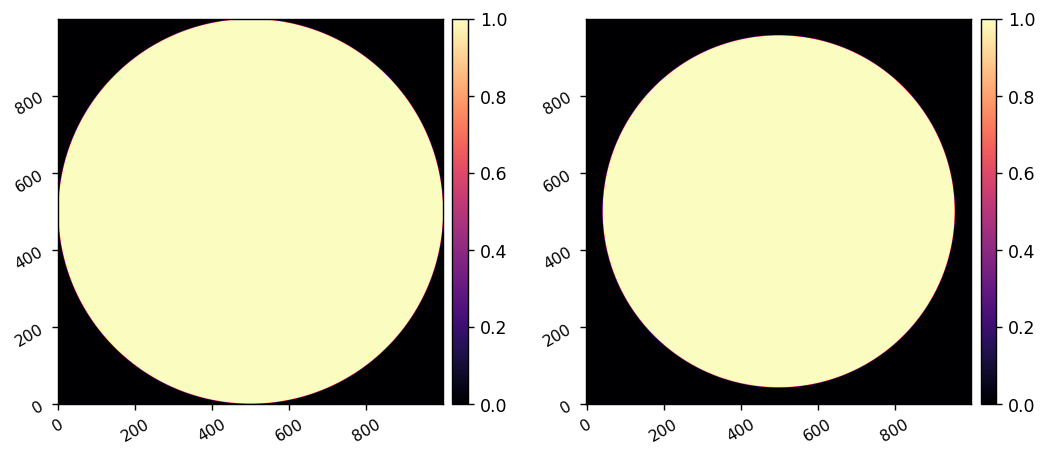

In [7]:
imshow2(m.APERTURE, m.LYOT, npix=m.npix)

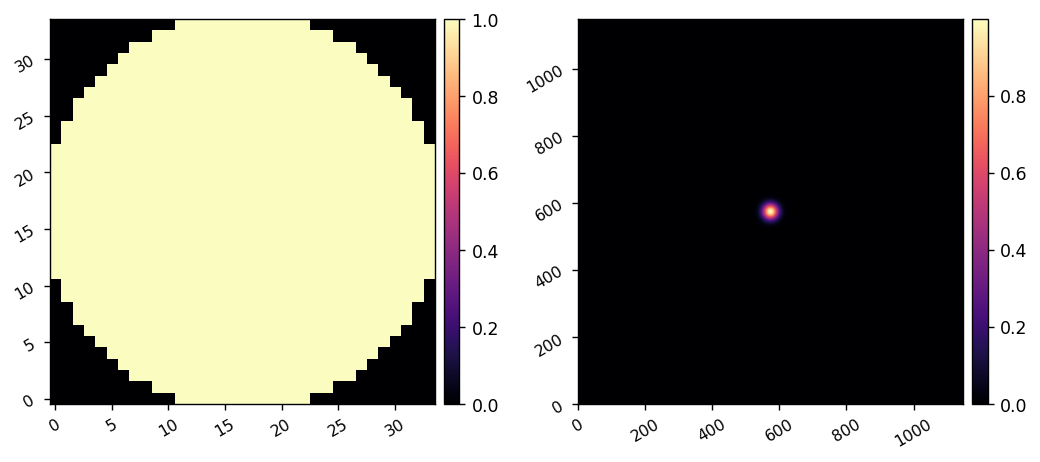

In [8]:
imshow2(m.dm_mask, m.inf_fun)

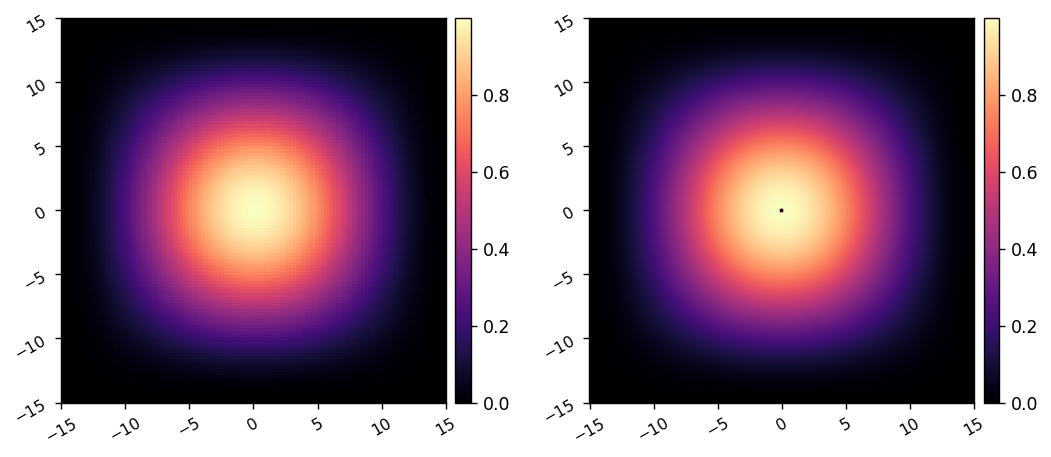

In [3]:
imshow2(m.lres_window, m.hres_window, npix1=m.lres_win_size,
        pxscl1=m.lres_sampling, pxscl2=m.hres_sampling)

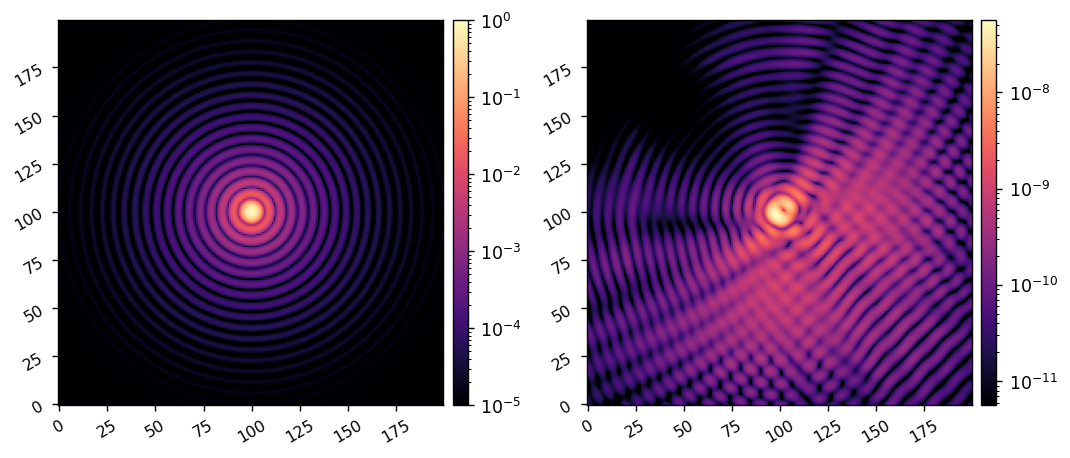

In [5]:
m.Imax_ref = 1
test_psf = xp.abs(m.forward(xp.zeros(m.Nacts), use_vortex=False, use_wfe=False))**2
m.Imax_ref = xp.max(test_psf)
test_coro_im = xp.abs(m.forward(xp.zeros(m.Nacts), use_vortex=True, use_wfe=False))**2
imshow2(test_psf/m.Imax_ref, test_coro_im, lognorm=True, vmin1=1e-5, vmin2=xp.max(test_coro_im)/1e4)

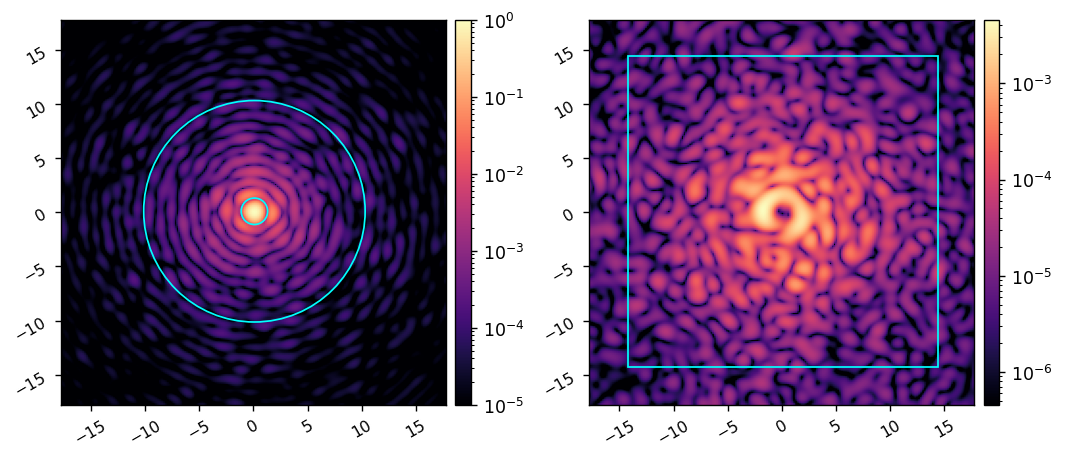

In [12]:
acts = np.zeros(m.Nacts)

# waffle_command = 10e-9 * xp.ones((m.Nact,m.Nact))
# waffle_command[1::2, ::2] *= -1
# waffle_command[::2, 1::2] *= -1
# acts = ensure_np_array(waffle_command[m.dm_mask]) 

m.Imax_ref = 1
ref_psf = xp.abs(m.forward(acts, use_vortex=False, use_wfe=True))**2
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2

imshow2(ref_psf/m.Imax_ref, ref_coro_im, 
        pxscl=m.psf_pixelscale_lamD, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-m.crad+m.psf_pixelscale_lamD/2, -m.crad+m.psf_pixelscale_lamD/2), m.crad*2, m.crad*2, fill=False, color='cyan', )],
        lognorm=True, vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)


# Test normal EFC

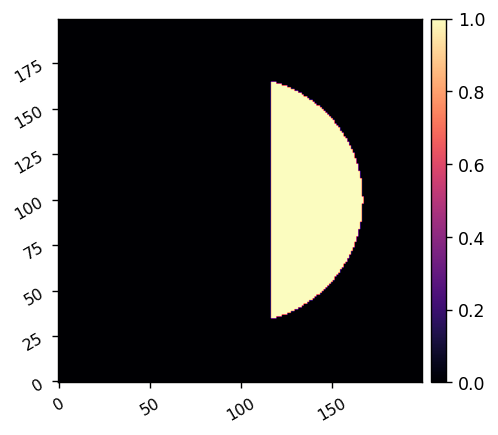

In [8]:
m.create_control_mask()
imshow1(m.control_mask)

In [13]:
reload(ad_scoob)

poke_modes = ad_scoob.create_poke_modes(m)

In [21]:
reload(ad_scoob)

jac = ad_scoob.compute_jacobian(m, poke_modes)


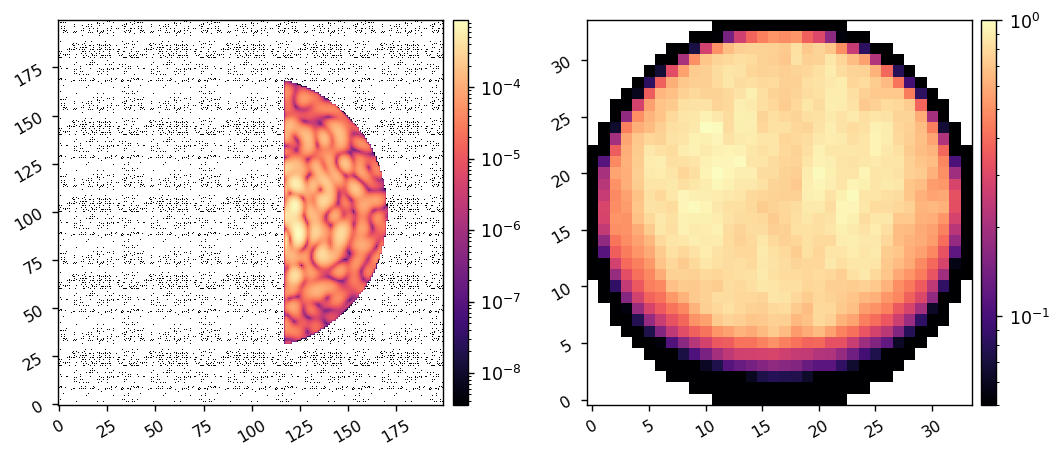

In [25]:
responses = jac[::2] + 1j*jac[1::2]
dm_response = xp.sqrt(xp.sum(xp.square(xp.abs(responses.dot(poke_modes.reshape(m.Nacts, m.Nact**2)))), axis=0)).reshape(m.Nact,m.Nact)
dm_response /= dm_response.max()
imshow2(m.control_mask*ref_coro_im, dm_response, lognorm=True, vmin2=5e-2)

In [26]:
all_ims = []
all_efs = []
all_commands = []

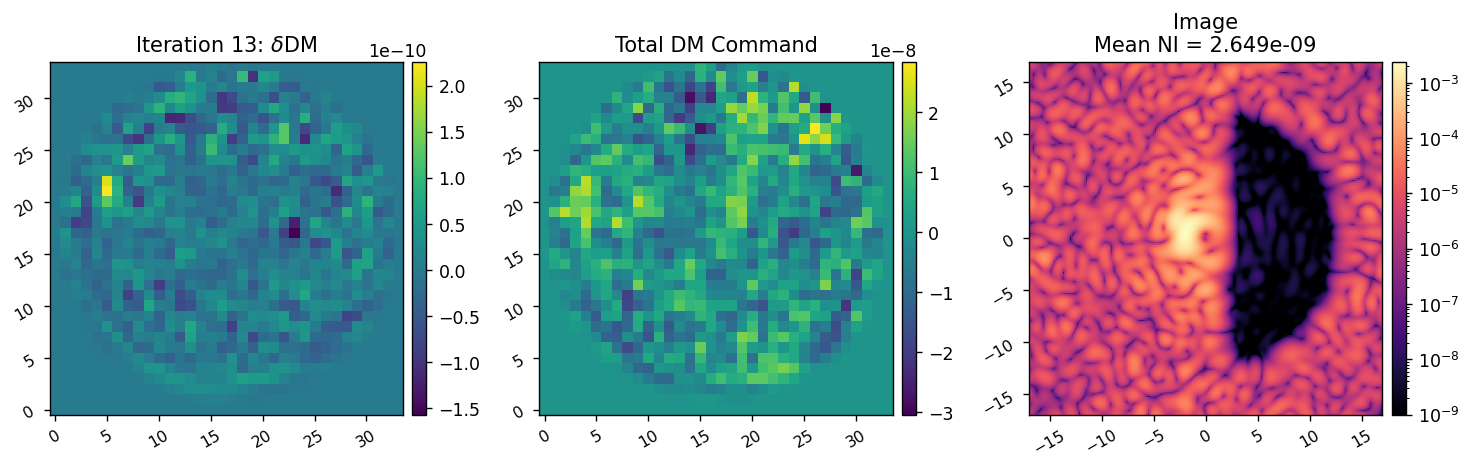

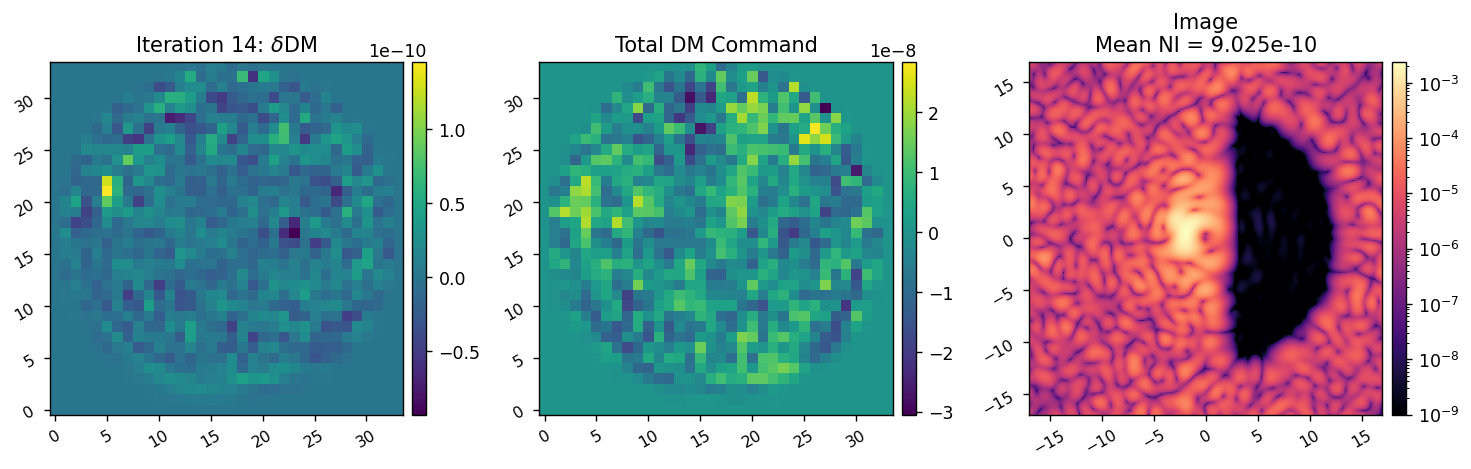

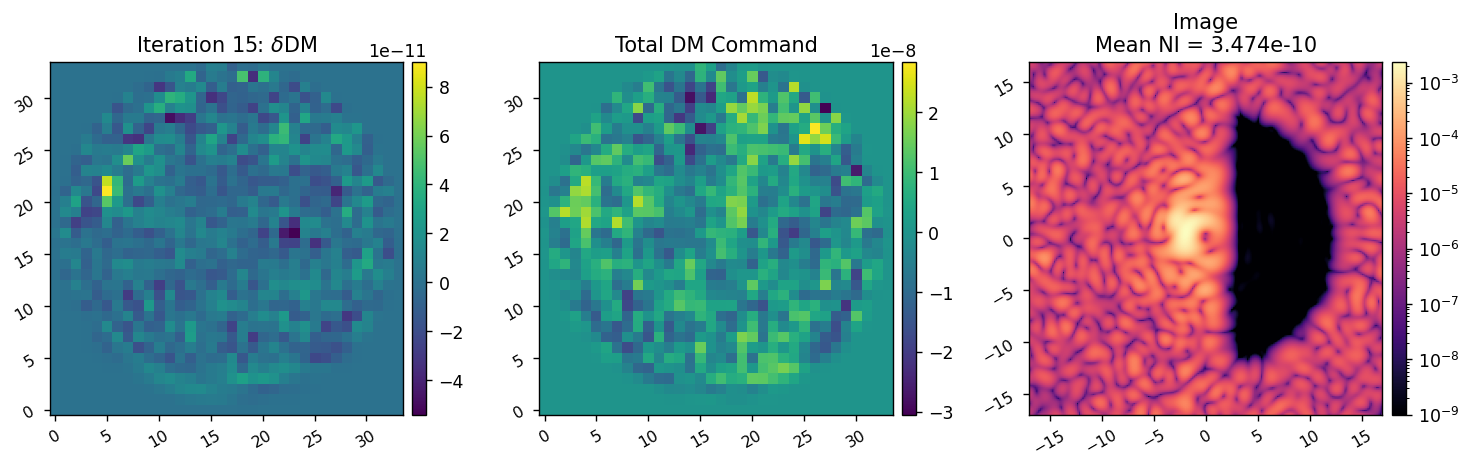

In [34]:
reload(ad_scoob)

cm = ad_scoob.beta_reg(jac, -2.5)
# cm = ad_scoob.beta_reg(jac, -4.5)

all_ims, all_efs, all_commands = ad_scoob.efc(m,
                                              cm, 
                                              Nitr=3, 
                                              nominal_command=all_commands[-1], 
                                              all_ims=all_ims, 
                                              all_efs=all_efs,
                                              all_commands=all_commands,
                                              )



# Test minimzation with L-BFGS-B

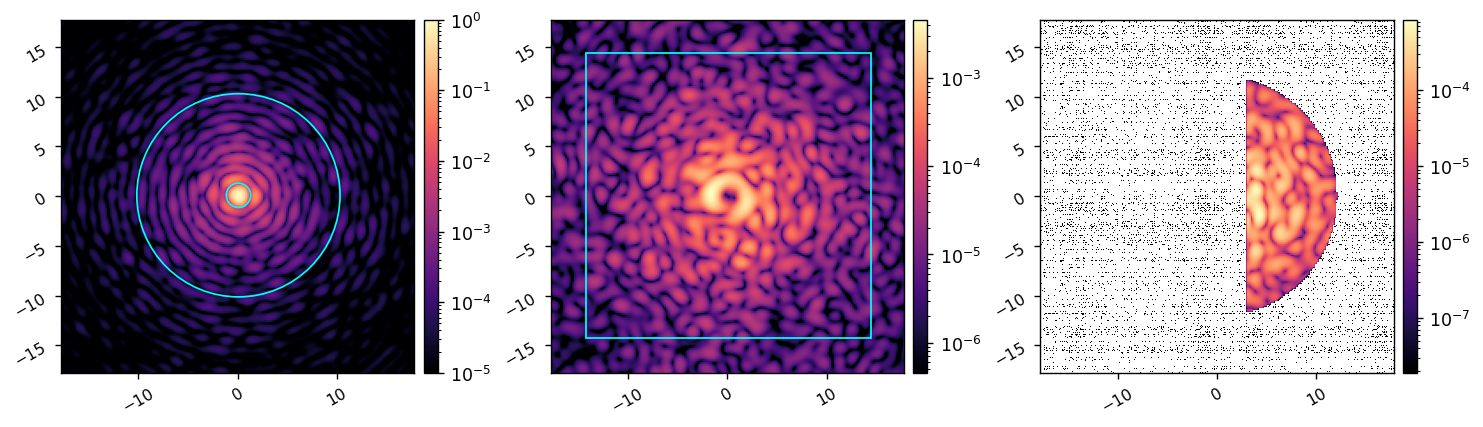

In [32]:
reload(ad_scoob)
m = ad_scoob.MODEL()
m.WFE = WFE
m.create_control_mask()

acts = np.zeros(m.Nacts)

ref_psf = xp.abs(m.forward(acts, use_vortex=False, use_wfe=True))**2
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = xp.abs(m.forward(acts, use_vortex=True, use_wfe=True))**2

imshow3(ref_psf/m.Imax_ref, ref_coro_im, m.control_mask*ref_coro_im, 
        pxscl=m.psf_pixelscale_lamD, 
        patches1=[Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((m.psf_pixelscale_lamD/2,m.psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-m.crad+m.psf_pixelscale_lamD/2, -m.crad+m.psf_pixelscale_lamD/2), m.crad*2, m.crad*2, fill=False, color='cyan', )],
        lognorm=True,  vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)

0.3261451405070691 0.0 0.3260577535750728 1.0002680105933326


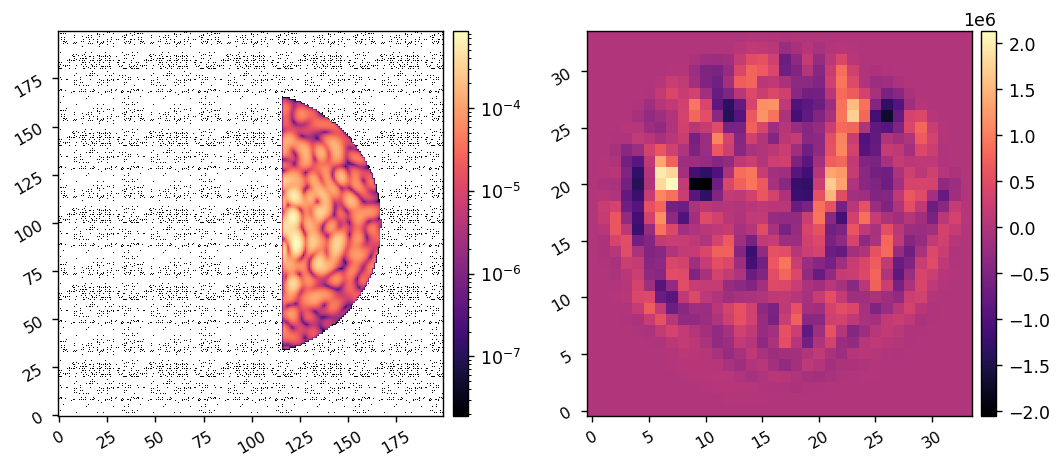

In [41]:
reload(ad_scoob)
del_acts = np.zeros(m.Nacts)
E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
r_cond = 1e-2
E_target = 0
E_model_nom = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)

J, dJ_dA = ad_scoob.val_and_grad(del_acts, 
                                 m,
                                 E_ab,
                                 r_cond=r_cond,
                                 E_target=E_target, 
                                 verbose=True,
                                )

dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
imshow2(m.control_mask*ref_coro_im, dm_grad, lognorm1=True)

# Does E_ep_k-1 contain the wavefront contribution from the total accumulated DM command?

In [42]:
acts = np.zeros(m.Nacts)
E_ab = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=True) * m.control_mask)
r_cond = 1e-2
E_target = 0
E_model_nom = ensure_np_array(m.forward(acts, use_vortex=True, use_wfe=False) * m.control_mask)

bfgs_tol = 1e-3
bfgs_opts = {
    'maxiter':20,
    # 'maxls':30, # default is 20
    'ftol':1e-6, 
    'gtol':1e-6,
    'disp':True, 
}

del_acts0 = np.zeros(m.Nacts)
res = minimize(ad_scoob.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(m, E_ab, r_cond, E_target, E_model_nom), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )
    

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.12966D+06


 This problem is unconstrained.



At iterate    1    f=  3.13236D-01    |proj g|=  1.15319D+06

At iterate    2    f=  1.19279D-01    |proj g|=  5.74471D+05

At iterate    3    f=  6.67719D-02    |proj g|=  4.79671D+05

At iterate    4    f=  3.69128D-02    |proj g|=  4.45865D+05

At iterate    5    f=  2.68674D-02    |proj g|=  3.98651D+05

At iterate    6    f=  1.54271D-02    |proj g|=  2.15919D+05

At iterate    7    f=  1.00878D-02    |proj g|=  9.31898D+04

At iterate    8    f=  8.45628D-03    |proj g|=  8.69476D+04

At iterate    9    f=  6.94942D-03    |proj g|=  1.79283D+05

At iterate   10    f=  5.31314D-03    |proj g|=  8.08042D+04

At iterate   11    f=  4.80284D-03    |proj g|=  1.50269D+05

At iterate   12    f=  4.11803D-03    |proj g|=  1.07725D+05

At iterate   13    f=  3.97054D-03    |proj g|=  8.76414D+04

At iterate   14    f=  3.72008D-03    |proj g|=  1.17490D+05

At iterate   15    f=  3.41148D-03    |proj g|=  8.82532D+04

At iterate   16    f=  2.84450D-03    |proj g|=  6.76312D+04

At iter

6.667847721371633e-05 8.346632950311635e-06


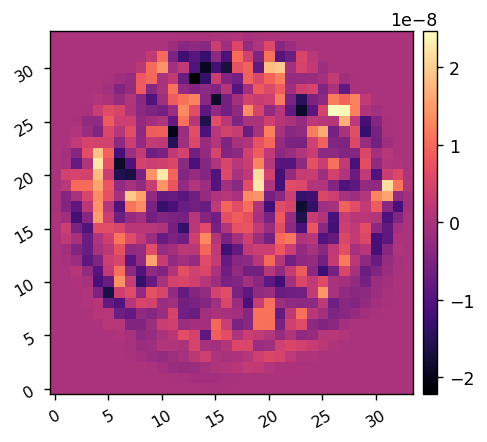

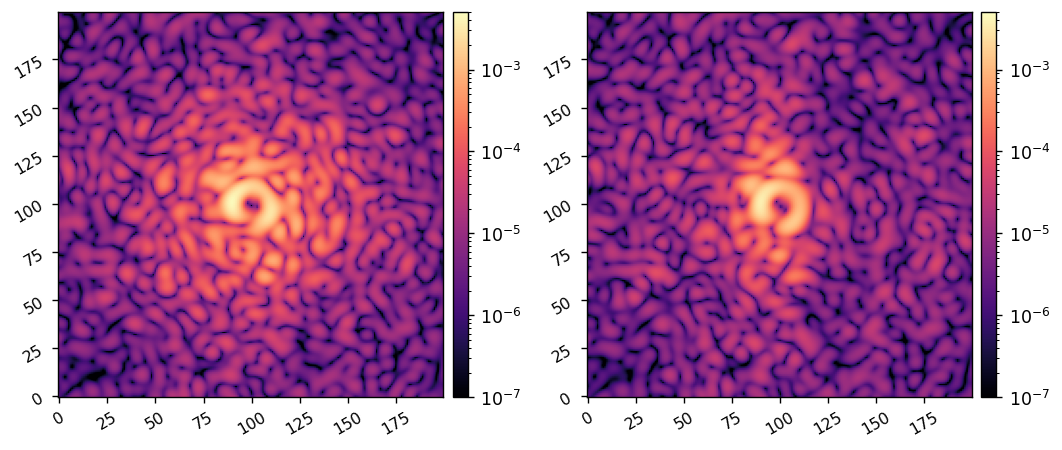

In [44]:
min_command = xp.zeros((m.Nact,m.Nact))
min_command[m.dm_mask] = res.x
coro_im = xp.abs(m.forward(res.x, use_wfe=True))**2

print(xp.mean(ref_coro_im[m.control_mask]), xp.mean(coro_im[m.control_mask]))
imshow1(min_command)
imshow2(ref_coro_im, coro_im, lognorm=True, vmin1=1e-7, vmin2=1e-7, vmax1=5e-3, vmax2=5e-3)

# Test a full EFC run with L-BFGS-B

In [52]:
reload(ad_efc)
reload(ad_scoob)


<module 'scoobpsf.ad_scoob_oop' from '/home/kianmilani/Projects/scoob-psf/scoobpsf/ad_scoob_oop.py'>

In [49]:
all_ims = []
all_efs = []
all_commands = []

bfgs_tol = 1e-3
bfgs_opts = {
    'maxiter':20,
    # 'maxls':30, # default is 20
    'ftol':1e-6, 
    'gtol':1e-6,
    'disp':False, 
}

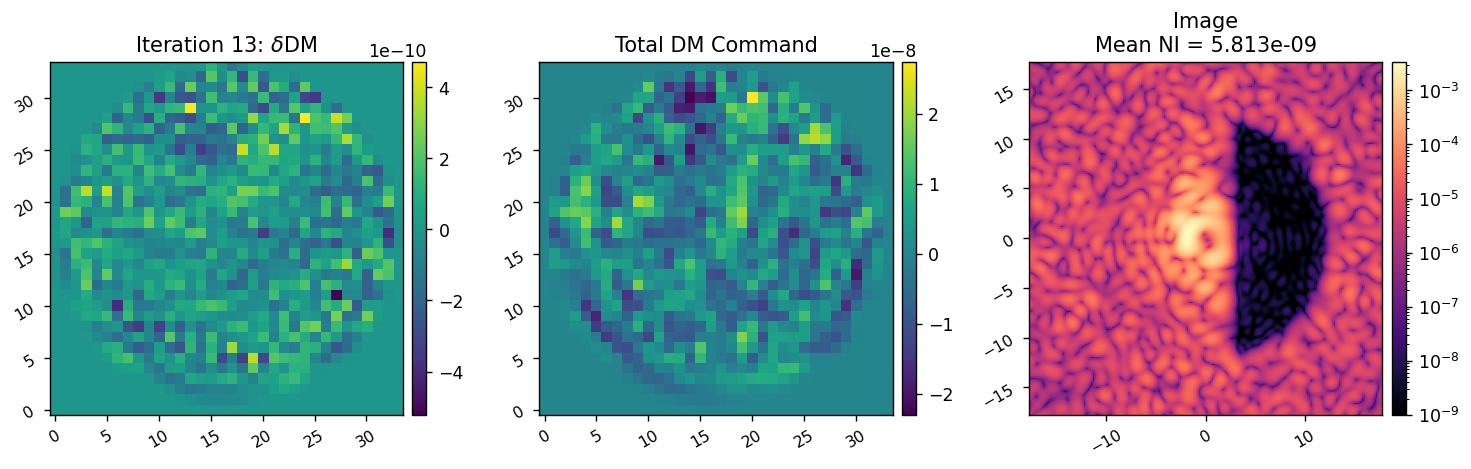

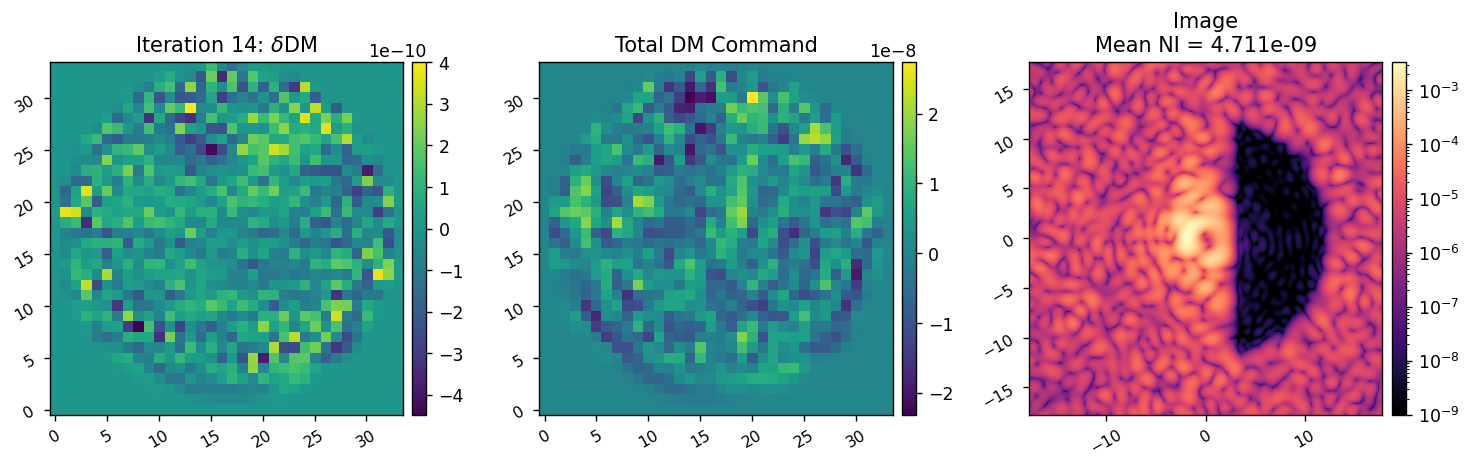

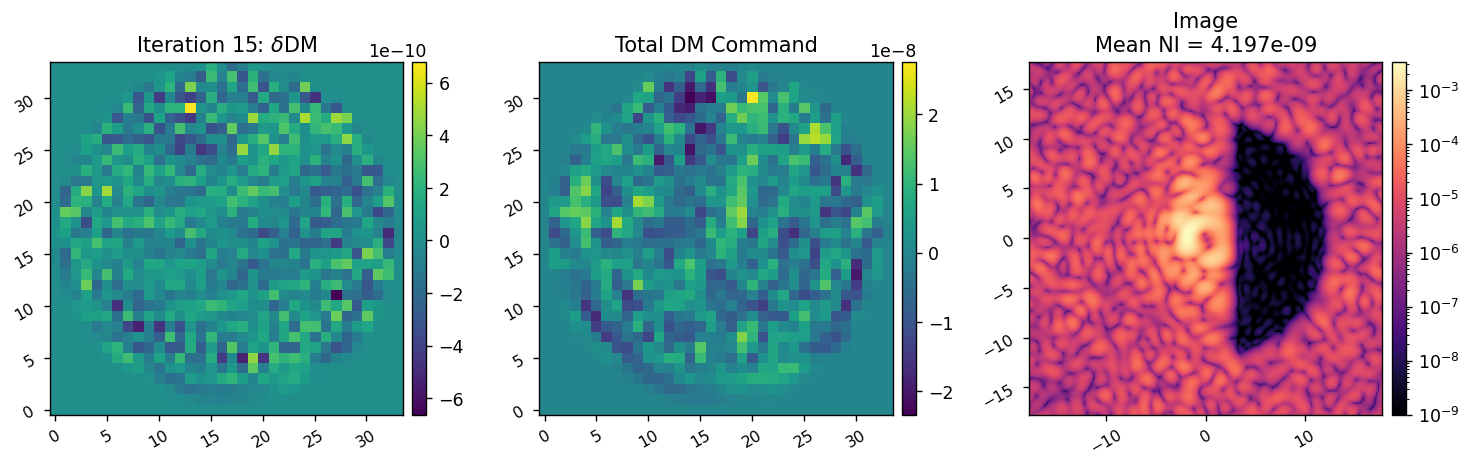

In [56]:
reg_cond = 1e-2
# reg_cond = 1e-3
reg_cond = 1e-4

all_ims, all_efs, all_commands = ad_efc.sim(m, ad_scoob.val_and_grad,
                                            Nitr=3, 
                                            nominal_command=all_commands[-1], 
                                            reg_cond=reg_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )

